# Speaker Diarization using malaya-speech with spectralClusterer

In [ ]:
%pip install malaya_speech spectralcluster

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # to stop tensorflow form loading cuda
import warnings  # noqa
warnings.filterwarnings("ignore")  # noqa
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to use `speakernet`.

`Downlaod`


Download the models:

* [speakernet](https://f000.backblazeb2.com/file/malaya-speech-model/speaker-vector/speakernet/model.pb)
  to:
  `<Home>\Malaya-Speech\speaker-vector`

In [2]:
model_speakernet = malaya_speech.speaker_vector.deep_model('speakernet',validate=False)

### Load audio sample

In [3]:
y, sr = malaya_speech.load('../../audio/conversations/2_speakers.en.wav')
len(y), sr

(719710, 16000)

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

`Downlaod`


Download the VAD:

* [vggvox-v2](https://f000.backblazeb2.com/file/malaya-speech-model/vad/vggvox-v2/model.pb)
  to:
  `<Home>\Malaya-Speech\vad\vggvox-v2`

In [4]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2',validate=False)

In [5]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

In [6]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)

In [7]:
result = p.emit(frames)
result.keys()

dict_keys(['batching', 'predict', 'flatten'])

In [8]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

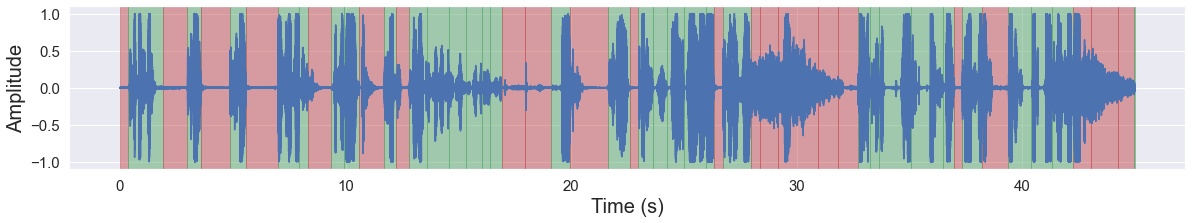

In [9]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (20, 3))

### Spectral Clustering

This is a Python re-implementation of the spectral clustering algorithm in the paper [Speaker Diarization with LSTM](https://google.github.io/speaker-id/publications/LstmDiarization/).

So, make sure you already install [spectralcluster](https://pypi.org/project/spectralcluster/),

```bash
pip install spectralcluster
```

```python
def spectral_cluster(
    vad_results,
    speaker_vector,
    min_clusters: int = None,
    max_clusters: int = None,
    p_percentile: float = 0.95,
    gaussian_blur_sigma = 1.0,
    norm_function: Callable = l2_normalize,
    log_distance_metric: str = None,
    return_embedding = False,
    **kwargs,
):
    """
    Speaker diarization using SpectralCluster, https://github.com/wq2012/SpectralCluster

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    min_clusters: int, optional (default=None)
        minimal number of clusters allowed (only effective if not None).
    max_clusters: int, optional (default=None)
        maximal number of clusters allowed (only effective if not None).
        can be used together with min_clusters to fix the number of clusters.
    gaussian_blur_sigma: float, optional (default=1.0)
        sigma value of the Gaussian blur operation.
    p_percentile: float, optional (default=0.95)
        the p-percentile for the row wise thresholding.
    norm_function: Callable, optional(default=malaya_speech.utils.dist.l2_normalize)
        normalize function for speaker vectors.
    log_distance_metric: str, optional (default=None)
        post distance norm in log scale metrics.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [10]:
result_diarization_sc_speakernet = malaya_speech.diarization.spectral_cluster(grouped_vad, model_speakernet,
                                                                             min_clusters = 2,
                                                                             max_clusters = 3)
result_diarization_sc_speakernet[:5]

[(<malaya_speech.model.frame.Frame at 0x24d0941e6c8>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24d0942c388>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x24d08818948>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x24d070f4e48>, 'speaker 1'),
 (<malaya_speech.model.frame.Frame at 0x24d09430f88>, 'not a speaker')]

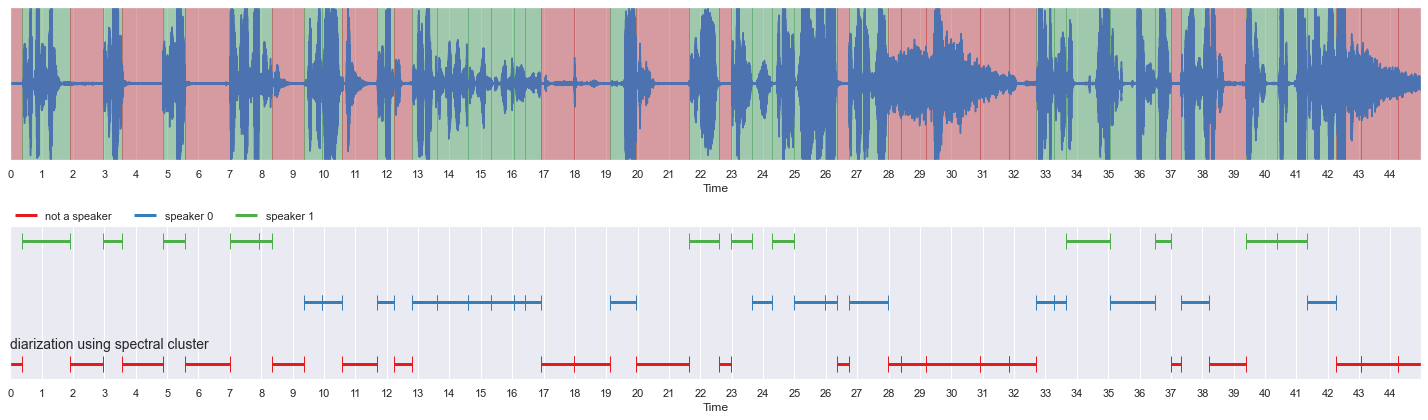

In [11]:
rows_num = 2
fig, ax = plt.subplots(nrows = rows_num, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(rows_num * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
ax[0].set_xticks(np.arange(0, 45, 1.0))
ax[1].set_xticks(np.arange(0, 45, 1.0))

malaya_speech.extra.visualization.plot_classification(result_diarization_sc_speakernet, 
                                                      'diarization using spectral cluster', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### How to get timestamp

1. Group multiple frames based on label, this can achieve using `malaya_speech.group.group_frames`.

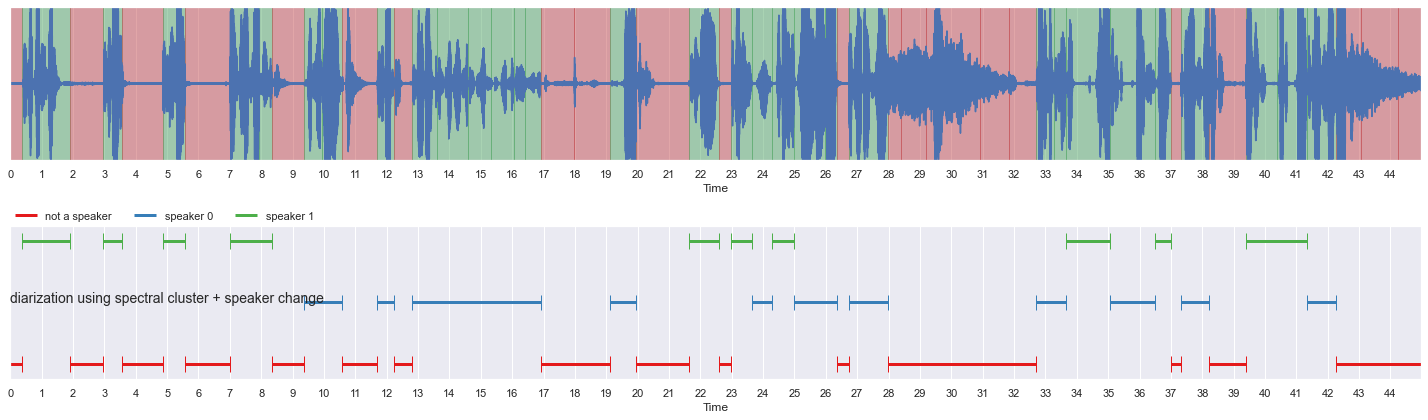

In [12]:
grouped = malaya_speech.group.group_frames(result_diarization_sc_speakernet)

nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(grouped, 
                                                      'diarization using spectral cluster + speaker change', 
                                                      ax = ax[1],
                                                     x_text = 0.01, y_text = 0.5)
ax[0].set_xticks(np.arange(0, 45, 1.0))
ax[1].set_xticks(np.arange(0, 45, 1.0))
fig.tight_layout()
plt.show()

In [13]:
grouped[0]

(<malaya_speech.model.frame.Frame at 0x24d1977fd08>, 'not a speaker')

`malaya_speech.model.frame.Frame` stores `timestamp` and `duration` attributes.

In [14]:
grouped[1][0].timestamp, grouped[1][0].duration, grouped[1][1]

(0.3600000000000001, 1.5300000000000002, 'speaker 1')

In [15]:
import json
frames =[]
for frame in grouped:
  start_time = round(frame[0].timestamp, 2)
  end_time = round(start_time + frame[0].duration,2)
  speaker = -1 if frame[1] == "not a speaker" else frame[1].replace("speaker ","")
  frames.append({"speaker": speaker,"start_time": start_time, "end_time":end_time})
print(json.dumps(frames,indent=2))

[
  {
    "speaker": -1,
    "start_time": 0.0,
    "end_time": 0.36
  },
  {
    "speaker": "1",
    "start_time": 0.36,
    "end_time": 1.89
  },
  {
    "speaker": -1,
    "start_time": 1.89,
    "end_time": 2.97
  },
  {
    "speaker": "1",
    "start_time": 2.97,
    "end_time": 3.57
  },
  {
    "speaker": -1,
    "start_time": 3.57,
    "end_time": 4.86
  },
  {
    "speaker": "1",
    "start_time": 4.86,
    "end_time": 5.58
  },
  {
    "speaker": -1,
    "start_time": 5.58,
    "end_time": 6.99
  },
  {
    "speaker": "1",
    "start_time": 6.99,
    "end_time": 8.34
  },
  {
    "speaker": -1,
    "start_time": 8.34,
    "end_time": 9.36
  },
  {
    "speaker": "0",
    "start_time": 9.36,
    "end_time": 10.59
  },
  {
    "speaker": -1,
    "start_time": 10.59,
    "end_time": 11.7
  },
  {
    "speaker": "0",
    "start_time": 11.7,
    "end_time": 12.24
  },
  {
    "speaker": -1,
    "start_time": 12.24,
    "end_time": 12.81
  },
  {
    "speaker": "0",
    "start_time